In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/test/NORMAL',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/NORMAL',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/val/NORMAL',
]

pneumonia_dir = [ 
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/test/PNEUMONIA',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/train/PNEUMONIA',
    r'C:/Users/tulsi/Desktop/Pneumonia-Detection-using-Deep-Learning/chest_xray/chest_xray/val/PNEUMONIA'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())


                                           filepaths  labels
0  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
1  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
2  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
3  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
4  C:/Users/tulsi/Desktop/Pneumonia-Detection-usi...  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [4]:
pneumonia_df.shape

(5856, 2)

In [5]:
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(4684, 2)
(1757, 2)
(1172, 2)
(4099, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 4684 validated image filenames belonging to 2 classes.
Found 1757 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Normal', 'Pneumonia']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,609,474 (59.55 MB)

 Trainable params: 15,603,074 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

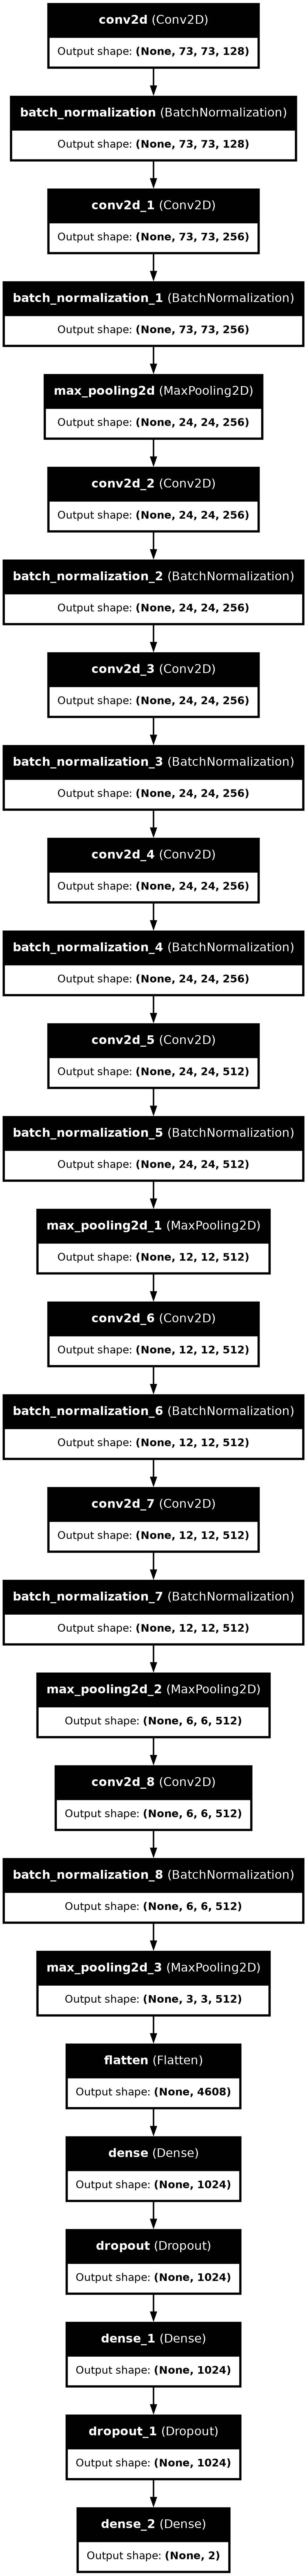

In [10]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1785s 2s/step - accuracy: 0.7874 - loss: 0.7168 - val_accuracy: 0.9497 - val_loss: 0.1362
Epoch 2/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1496s 1s/step - accuracy: 0.9013 - loss: 0.2602 - val_accuracy: 0.9505 - val_loss: 0.1432
Epoch 3/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1478s 1s/step - accuracy: 0.9361 - loss: 0.1670 - val_accuracy: 0.9514 - val_loss: 0.1305
Epoch 4/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1478s 1s/step - accuracy: 0.9553 - loss: 0.1109 - val_accuracy: 0.9582 - val_loss: 0.1147
Epoch 5/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1463s 1s/step - accuracy: 0.9663 - loss: 0.1033 - val_accuracy: 0.9573 - val_loss: 0.1147
Epoch 6/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1437s 1s/step - accuracy: 0.9657 - loss: 0.0895 - val_accuracy: 0.9616 - val_loss: 0.1237
Epoch 7/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1482s 1s/step - accuracy: 0.9751 - loss: 0.0769 - val_accuracy: 0.9522 - val_loss: 0.1291
Epoch 8/10
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 1494s 1s/step - accuracy: 0.9815 -

In [12]:
model.evaluate(test, verbose=1)

440/440 ━━━━━━━━━━━━━━━━━━━━ 136s 309ms/step - accuracy: 0.9588 - loss: 0.1405


[0.10165897756814957, 0.9675583243370056]

In [13]:
model.save("pneumonia_Model.h5")

In [14]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

440/440 ━━━━━━━━━━━━━━━━━━━━ 138s 312ms/step


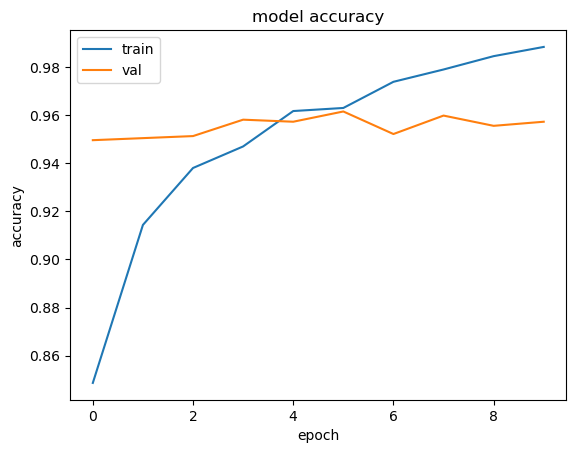

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

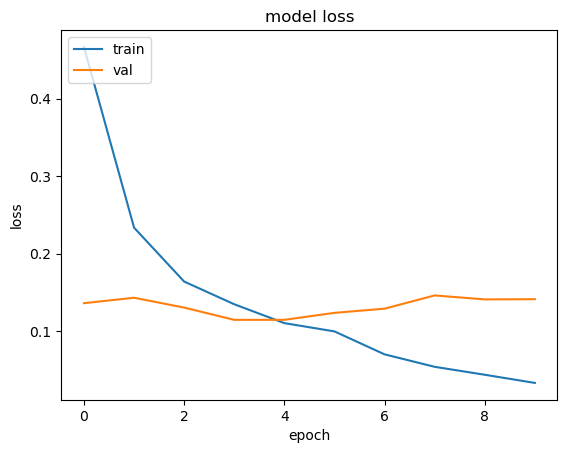

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94       505
   Pneumonia       0.98      0.98      0.98      1252

    accuracy                           0.97      1757
   macro avg       0.96      0.96      0.96      1757
weighted avg       0.97      0.97      0.97      1757

Accuracy of the Model: 96.8%


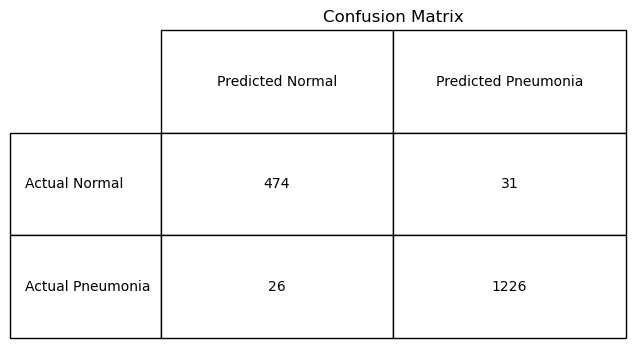

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, pred2)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=[f'Actual {label}' for label in class_labels], columns=[f'Predicted {label}' for label in class_labels])

# Display the confusion matrix as a table
plt.figure(figsize=(6, 4))
plt.table(cellText=cm_df.values, colLabels=cm_df.columns, rowLabels=cm_df.index, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0, 1, 1])

# Remove axes
plt.axis('off')

# Title
plt.title('Confusion Matrix')

# Show the table
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


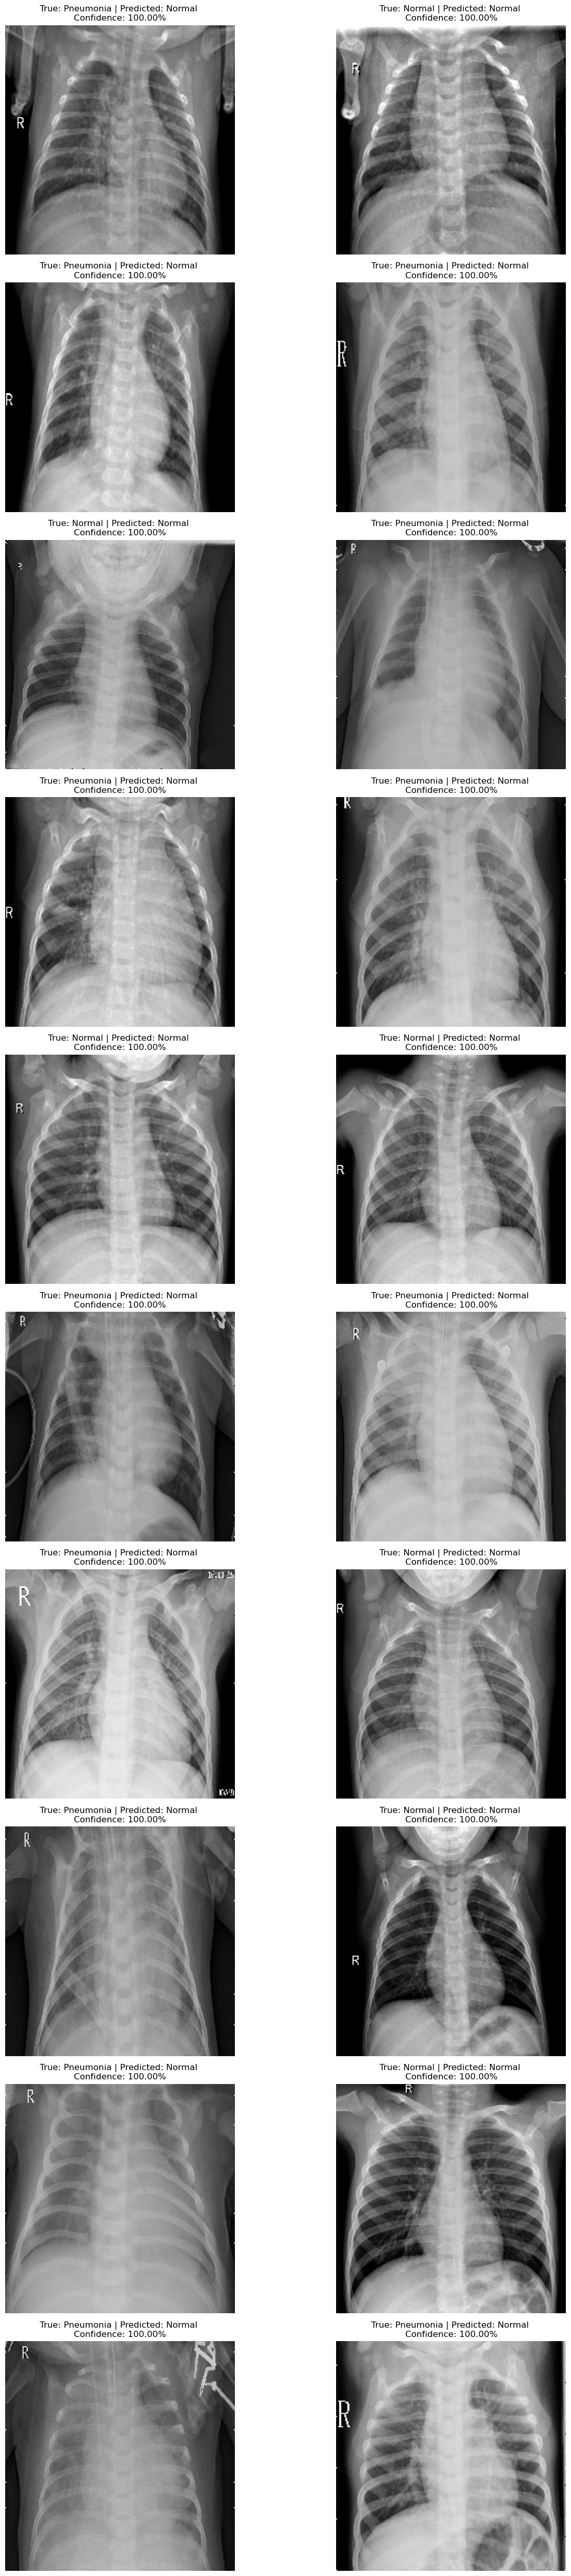

In [54]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Function to display random predictions with confidence scores (2 images per row)
def show_random_predictions_with_confidence(model, test_set, num_images=10, img_size=(224, 224)):  
    # Map class indices to labels
    class_labels = list(test_set.class_indices.keys())
    
    # Select random images from the test set
    random_indices = random.sample(range(len(test_set.filepaths)), num_images)
    selected_images = [test_set.filepaths[i] for i in random_indices]
    selected_labels = [test_set.labels[i] for i in random_indices]
    
    # Initialize figure for displaying results (2 images per row)
    rows = (num_images + 1) // 2  # Calculate number of rows needed
    plt.figure(figsize=(15, rows * 5))  # Adjust the height based on the number of rows
    
    for idx, img_path in enumerate(selected_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=img_size)  # Resize image to the desired size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make a prediction
        predictions = model.predict(img_array)
        predicted_label = class_labels[np.argmax(predictions)]
        true_label = class_labels[selected_labels[idx]]
        prediction_probs = predictions[0]  # Probabilities for each class
        
        # Display the image and prediction with probability in two columns per row
        plt.subplot(rows, 2, idx + 1)  # Arrange images in 2 columns per row
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label} \nConfidence: {max(prediction_probs) * 100:.2f}%", fontsize=12)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Call the function to display predictions with confidence
show_random_predictions_with_confidence(model, test, num_images=20, img_size=(224, 224))  # Change img_size to adjust image display size
